In [9]:
# first we import the libraries we will be working with 
import json
import geoplot
import numpy as np
import pyproj
import json
import requests

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

from functools import partial
from shapely.ops import transform
from io import StringIO
from shapely.geometry import Point, Polygon, mapping

import os,sys

%matplotlib inline

In [10]:
datadir = r"C:\Users\Timo\AppData\Local\Temp\GBON-data"

if not os.path.isdir(datadir):
    print("warning.. download data from https://wmoomm.sharepoint.com/:u:/s/Infrastructure/ERmDAEu4ZNROvnYT3grX33UBC-FZIItGjCjBT404R0ecyw?e=vlXRMN")
    sys.exit(1)
    
def make_grid(length=10,width=10):
    xmin,ymin,xmax,ymax = (-180,-90,180,90)

    cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax)), width))
    rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax)), length))
    rows.reverse()

    polygons = []
    for x in cols:
        for y in rows:
            polygons.append( Polygon([(x,y), (x+width, y), (x+width, y-length), (x, y-length)]) )

    grid = gpd.GeoDataFrame({'geometry':polygons})
    #grid.crs = {'init' :'epsg:4326'}  
    grid.crs = "epsg:4326"
    
    return grid

In [3]:
world_shapefile = os.path.join( datadir , "WMO/WMO_basemap.shp" )

gdf_world = gpd.read_file( world_shapefile )
gdf_world.crs = "epsg:4326"
gdf_world=gdf_world
gdf_world.head(2)

,STATUS,TERR_NAME,POL_C_CODE,ABBREV,SHORT_NAME,ISO_2_CODE,LABELRANK,geometry
0,WMO Member,Afghanistan,AFG,Afg.,Afghanistan,AF,2.0,"POLYGON ((71.26610 37.98232, 71.25214 37.92794..."
1,WMO Member,Angola,AGO,Ang.,Angola,AO,2.0,"MULTIPOLYGON (((13.99750 -5.84861, 14.08028 -5..."


In [4]:
grid = make_grid(width=1,length=1)
len(grid)

64800

In [5]:
# EEZs and inland waters
gdf_eez = gpd.read_file(os.path.join( datadir , 'EEZ/eez_v10.shp') )
gdf_inland_water = gpd.read_file(os.path.join( datadir , 'EEZ/eez_internal_waters_v2.shp') )

gdf_eez=gdf_eez[gdf_eez["Pol_type"]=='200NM'] # remove disputed
gdf_inland_water.set_index("ISO_Ter1",inplace=True)

gdf_eez.set_index("ISO_Ter1",inplace=True)
df_eez = gdf_eez.reset_index().groupby('ISO_Ter1')["Area_km2"].sum().to_frame()
df_eez.columns = ['eez_area_km2']
df_eez.loc['DNK','eez_area_km2'] += df_eez.loc['GRL','eez_area_km2']
gdf_world=gdf_world.join(df_eez,on="POL_C_CODE") # add EEZ to our dataframe

df_int_water = gdf_inland_water.groupby('ISO_Ter1')["Area_km2"].sum().to_frame()
df_int_water.columns = ['int_water_km2']
df_int_water.loc['DNK','int_water_km2'] += df_int_water.loc['GRL','int_water_km2']
gdf_world=gdf_world.join(df_int_water,on="POL_C_CODE") # add inland water to our dataframe

In [6]:
df_surface_area = pd.read_csv( os.path.join( datadir ,  'WB\API_AG.LND.TOTL.K2_DS2_en_csv_v2_10578310.csv'),skiprows=4)
df_surface_area = df_surface_area.set_index("Country Code")
df_surface_area.loc['DNK','2017'] += df_surface_area.loc['GRL','2017'] # combine Denmark and Greenland
df_surface_area = df_surface_area[["Country Name","2017"]].rename(columns={"2017":"surface_area_km2_wb"})
len(df_surface_area)

264

In [7]:
# add computed and World Bank land area size and create totals
gdf_world_area=gdf_world.join((gdf_world.to_crs("+proj=eqearth").area/10**6).to_frame().rename(columns={0:"surface_area_km2_comp"}))
gdf_world_area=gdf_world_area.join(df_surface_area,on="POL_C_CODE")
# no WB data for South Sudan and Sudan.. use GIS calculated values 
sdn_idx = gdf_world_area.POL_C_CODE.isin(["SDN","SSD"])
gdf_world_area.loc[sdn_idx,"surface_area_km2_wb"] = gdf_world_area.loc[sdn_idx,"surface_area_km2_comp"]

gdf_world_area["surface_area_total_km2"] = gdf_world_area[["surface_area_km2_wb","eez_area_km2","int_water_km2"]].sum(axis=1) 
gdf_world_area=gdf_world_area[["STATUS","TERR_NAME","POL_C_CODE","geometry","surface_area_km2_comp","surface_area_km2_wb","surface_area_total_km2","eez_area_km2","int_water_km2"]]
gdf_world_area=gdf_world_area.set_index("POL_C_CODE")
gdf_world_area.head(2)

,STATUS,TERR_NAME,geometry,surface_area_km2_comp,surface_area_km2_wb,surface_area_total_km2,eez_area_km2,int_water_km2
POL_C_CODE,,,,,,,,
AFG,WMO Member,Afghanistan,"POLYGON ((71.26610 37.98232, 71.25214 37.92794...",6.419079e+05,652860.0,652860.0,NaN,NaN
AGO,WMO Member,Angola,"MULTIPOLYGON (((13.99750 -5.84861, 14.08028 -5...",1.247366e+06,1246700.0,1745798.0,497800.0,1298.0


In [30]:
station_file = os.path.join( datadir , "WMO/station.json")

df_stations = pd.read_json( station_file )
geometry = [Point(xy) for xy in zip(df_stations.longitude , df_stations.latitude)]
crs =  'epsg:4326' 
gdf_stations = gpd.GeoDataFrame(df_stations, crs=crs, geometry=geometry)
len(gdf_stations)

15677

In [13]:
# compute crude country level HR ( land area / nr stations  )
stations_by_country = gpd.sjoin(gdf_world_area.reset_index(),gdf_stations,op="contains",how="inner").groupby("POL_C_CODE").TERR_NAME.count().to_frame()
stations_by_country = stations_by_country.rename(columns={"TERR_NAME":"nr_stations"})
gdf_world_area_stations = gdf_world_area.join(stations_by_country)
gdf_world_area_stations["HR"] = np.sqrt(gdf_world_area_stations.surface_area_km2_wb) / np.sqrt(gdf_world_area_stations.nr_stations)
gdf_world_area_stations.sort_values("HR",ascending=True)[["TERR_NAME","HR","nr_stations","surface_area_total_km2"]].head()

,TERR_NAME,HR,nr_stations,surface_area_total_km2
POL_C_CODE,,,,
NRU,Nauru,2.581989,3.0,310667.000000
TUV,Tuvalu,3.872983,2.0,756343.000000
MAC,"Macao, China",3.898718,2.0,30.400000
BMU,Bermuda,7.348469,1.0,453507.000001
HKG,"Hong Kong, China",8.100926,16.0,1050.000000


Text(0.5, 1.0, 'Horizontal Resolution by Country, including EEZ')

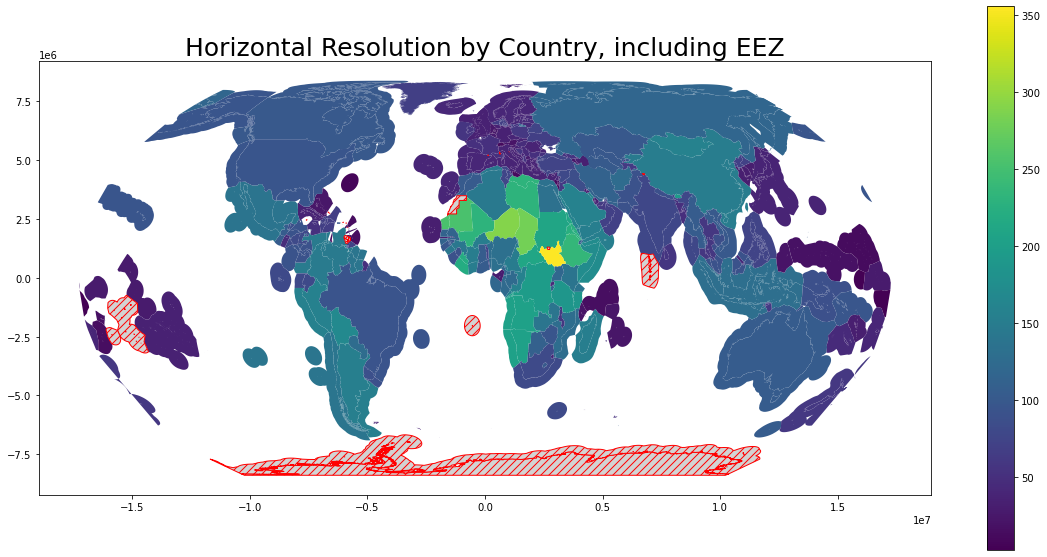

In [14]:
missing = {   "color": "lightgrey", "edgecolor": "red",
               "hatch": "///", "label": "Missing values" }

min_hr = gdf_world_area_stations.HR.min()
max_hr = gdf_world_area_stations.HR.max()

idx_missing = gdf_world_area_stations.HR.isna()
ax=gdf_world_area_stations[~idx_missing].to_crs("+proj=eqearth").plot(column="HR", legend=True, vmin=min_hr, vmax=max_hr, figsize=(20,10))
gdf_world_area_stations[idx_missing].to_crs("+proj=eqearth").plot(ax=ax, **missing)

#missing_kwds=missing

# add EEZ
gdf_eez_plus = gdf_eez.join(gdf_world_area_stations[["HR",]],how='inner')
idx_missing = gdf_eez_plus.HR.isna()
gdf_eez_plus[~idx_missing].to_crs("+proj=eqearth").plot(column="HR", legend=False, vmin=min_hr, vmax=max_hr, ax=ax)
gdf_eez_plus[idx_missing].to_crs("+proj=eqearth").plot(ax=ax,**missing)


ax.set_title("Horizontal Resolution by Country, including EEZ", fontsize=25)

In [15]:
gdf_world_area_stations[gdf_world_area_stations.HR.isna()][["TERR_NAME","HR","nr_stations","surface_area_total_km2"]]

,TERR_NAME,HR,nr_stations,surface_area_total_km2
POL_C_CODE,,,,
AND,Andorra,NaN,NaN,470.0
ATA,Antarctica,NaN,92.0,9550534.0
BCT,British Caribbean Territories,NaN,3.0,0.0
COK,Cook Islands,NaN,5.0,1976459.0
ESH,Western Sahara,NaN,3.0,0.0
GRD,Grenada,NaN,NaN,26010.0
MCO,Monaco,NaN,NaN,289.0
MDV,Maldives,NaN,NaN,929635.0
NIU,Niue,NaN,4.0,319089.0


In [16]:
# eqearth 

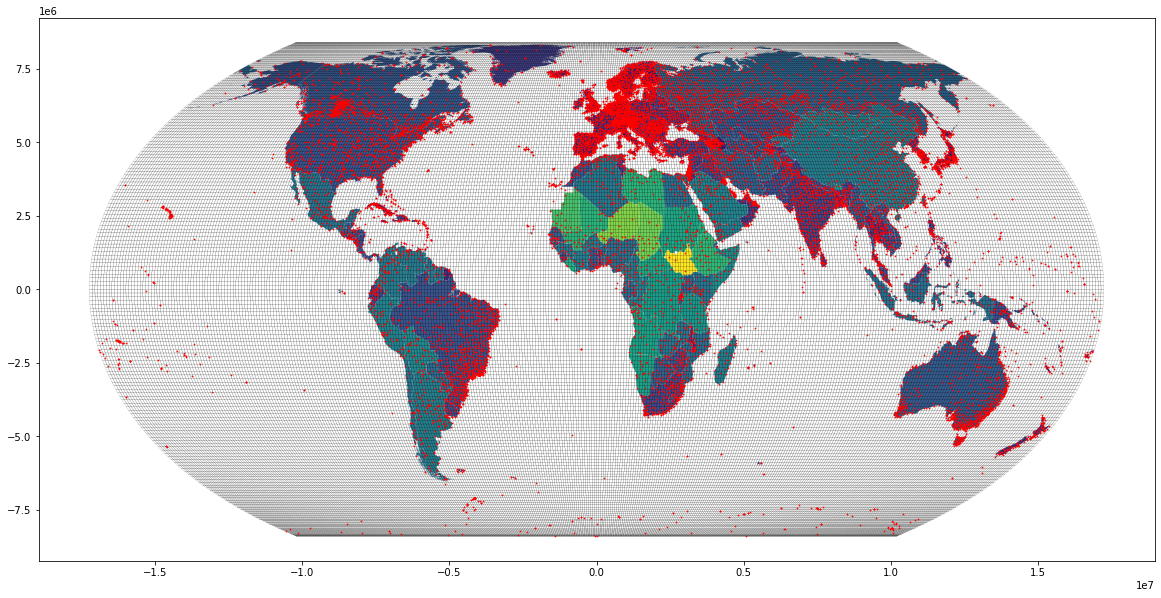

In [17]:
ax=gdf_world_area_stations.to_crs("+proj=eqearth").plot(column="HR" , figsize=(20,10))
grid.to_crs("+proj=eqearth").plot(ax=ax,facecolor="none",edgecolor="black", linewidth=0.1)
gdf_stations.to_crs("+proj=eqearth").plot(ax=ax,color="red",markersize=0.5)

# BF only

In [18]:
gdf_bf = gdf_world[gdf_world.TERR_NAME.str.contains("Faso")]
grid_bf = gpd.sjoin(grid,gdf_bf,op="intersects",how="inner")
stations_bf  = gpd.sjoin(gdf_stations,gdf_bf,op="intersects",how="inner")

Text(0.5, 1.0, 'Burkina Faso with 1 degree grid and stations')

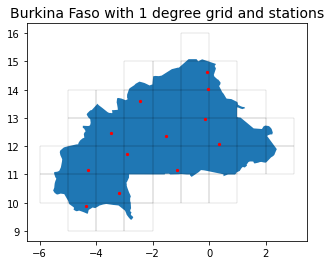

In [19]:
ax=gdf_bf.plot()
grid_bf.plot(ax=ax,facecolor="none",edgecolor="black", linewidth=0.1)
stations_bf.plot(ax=ax,color="red",markersize=5)
ax.set_title("Burkina Faso with 1 degree grid and stations", fontsize=14)

# join stations and countries

In [20]:
gpd.sjoin(gdf_world_area.reset_index(),gdf_stations,op="contains",how="inner").groupby("POL_C_CODE").TERR_NAME.count().sort_values(ascending=False).head(10)

POL_C_CODE
RUS    1193
USA     989
BRA     933
CAN     910
AUS     715
IND     489
CHN     416
ESP     314
KAZ     282
DEU     277
Name: TERR_NAME, dtype: int64

In [21]:
gdf_stations.groupby("territory").region.count().sort_values(ascending=False).head(10)

territory
Russian Federation     1268
United States (the)    1121
Canada                 1025
Brazil                  992
Australia               855
India                   520
China                   440
Spain                   342
Japan                   333
Norway                  311
Name: region, dtype: int64

# radius

Text(0.5, 1.0, 'Burkina Faso covered by stations with 100km radius')

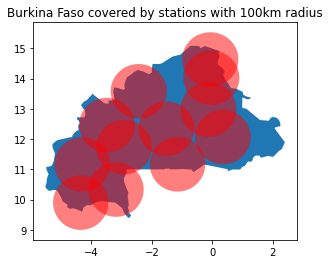

In [22]:
def make_circle(x,y,radius):
    point = Point(x, y)

    local_azimuthal_projection = f"+proj=aeqd +R=6371000 +units=m +lat_0={point.y} +lon_0={point.x}"

    wgs84_to_aeqd = partial(
        pyproj.transform,
        pyproj.Proj('+proj=longlat +datum=WGS84 +no_defs'),
        pyproj.Proj(local_azimuthal_projection),
    )

    aeqd_to_wgs84 = partial(
        pyproj.transform,
        pyproj.Proj(local_azimuthal_projection),
        pyproj.Proj('+proj=longlat +datum=WGS84 +no_defs'),
    )

    point_transformed = transform(wgs84_to_aeqd, point)
    buffer = point_transformed.buffer(radius)
    buffer_wgs84 = transform(aeqd_to_wgs84, buffer)

    return buffer_wgs84


newdata = gpd.GeoDataFrame()
newdata['geometry'] = None
newdata.crs = "epsg:4326"

for i,row in stations_bf.iterrows():   
    circle = make_circle(row["longitude"],row["latitude"],100_100)
    newdata.loc[i-1, 'geometry'] = circle
   
ax=gdf_bf.plot()
newdata.plot(ax=ax,color="red",alpha=0.5)
ax.set_title("Burkina Faso covered by stations with 100km radius",fontsize=12)

# density of RA I

In [23]:
data = requests.get("https://cpdb.wmo.int/data/members.json",verify=False).json()

df_wmo_members = pd.read_json( json.dumps(data["countries"])  ).transpose().set_index("id")
df_wmo_members

C:\Users\Timo\Anaconda3\envs\workenv\lib\site-packages\urllib3\connectionpool.py:851: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


,country_name,french_name,wmo_region_id,regional_involvement,wmo_membership,link
id,,,,,,
AFG,Afghanistan,Afghanistan,II,II,1956-09-11,https://cpdb.wmo.int/dashboard/afghanistan
ALB,Albania,Albanie,VI,VI,1957-07-29,https://cpdb.wmo.int/dashboard/albania
DZA,Algeria,Algérie,I,I,1963-04-04,https://cpdb.wmo.int/dashboard/algeria
AND,Andorra,Andorre,VI,VI,-0001-11-30,https://cpdb.wmo.int/dashboard/andorra
AGO,Angola,Angola,I,I,1977-03-16,https://cpdb.wmo.int/dashboard/angola
ATG,Antigua and Barbuda,Antigua-et-Barbuda,IV,IV,1988-11-16,https://cpdb.wmo.int/dashboard/antigua-and-bar...
ARG,Argentina,Argentine,III,III,1951-01-02,https://cpdb.wmo.int/dashboard/argentina
ARM,Armenia,Arménie,VI,VI,1992-09-16,https://cpdb.wmo.int/dashboard/armenia
AUS,Australia,Australie,V,V,1949-03-14,https://cpdb.wmo.int/dashboard/australia


In [24]:
gdf_world_area_stations_region = gdf_world_area_stations.join(df_wmo_members["wmo_region_id"])
gdf_africa = gdf_world_area_stations_region[gdf_world_area_stations_region.wmo_region_id == "I"]

gdf_african_stations = gpd.sjoin(gdf_stations,gdf_africa,op="intersects",how="inner")

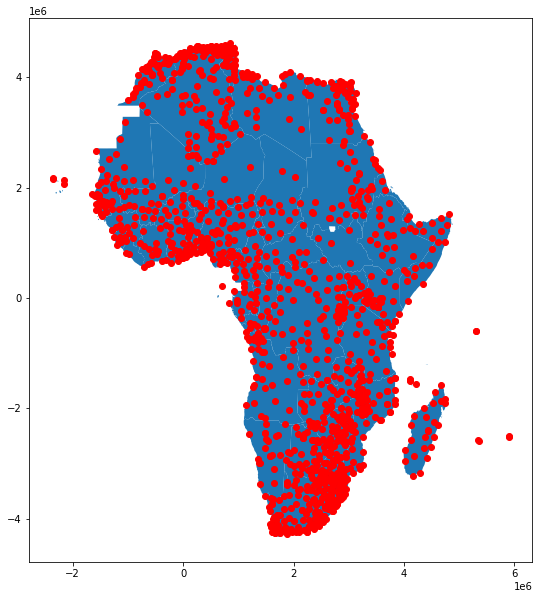

In [25]:
ax=gdf_africa.to_crs("+proj=eqearth").plot(figsize=(15,10))
gdf_african_stations.to_crs("+proj=eqearth").plot(ax=ax,color="red")

Text(0.5, 1.0, 'Kernel Density Estimation of HR of RA I')

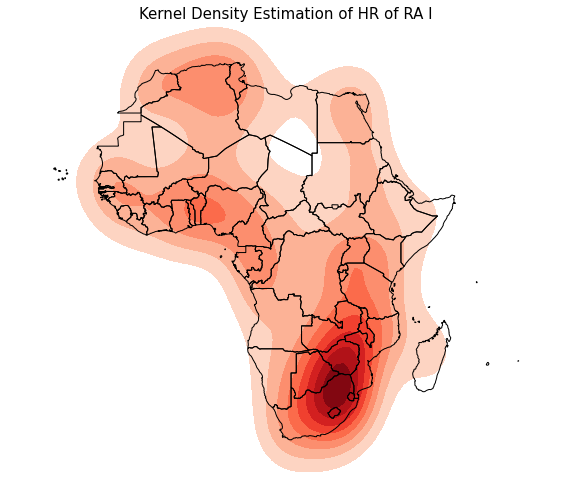

In [26]:
ax= geoplot.kdeplot(
        gdf_african_stations, 
        shade=True, cmap='Reds', figsize=(10,10)
          )

geoplot.polyplot(gdf_africa, ax=ax, zorder=1)

ax.set_title("Kernel Density Estimation of HR of RA I" ,fontsize=15)

# KDE with sklearn
using a more low level library we can better access crucial parameters 
I am using a different basemap for convenience here (can be changed later)


In [27]:
import json
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KernelDensity
from mpl_toolkits.basemap import Basemap


In [28]:
def construct_grids(data,width=0.05,borderspace=5):
    y_min = data[:,0].min() - borderspace
    y_max = data[:,0].max() + borderspace

    x_min = data[:,1].min() - borderspace
    x_max = data[:,1].max() + borderspace

    x_steps = (x_max-x_min) / width
    y_steps = (y_max-y_min) / width
    
    xgrid = np.linspace(x_min,x_max,x_steps)
    ygrid = np.linspace(y_min,y_max,y_steps)
    
    return [xgrid,ygrid]

In [31]:
latlong=np.array([ [s["latitude"],s["longitude"]] for s in json.load(open(station_file,encoding="utf8")) if "region" in s and s["region"] == "Africa" ])
xgrid, ygrid = construct_grids(latlong)
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy) # no land mask

Text(0.5, 1.0, 'RA-I stations')

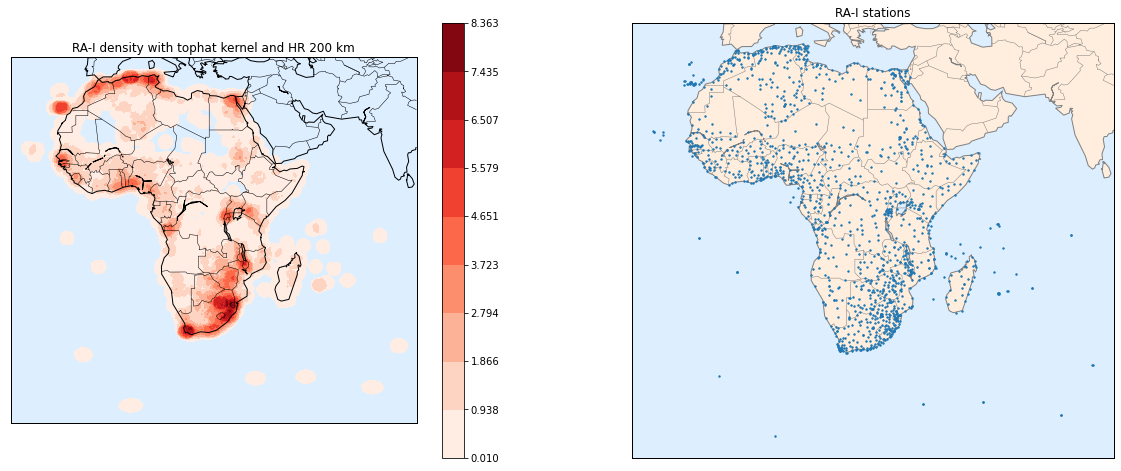

In [32]:
# distance as measured by haversine. Multiply by 6371000/1000 to get distaince in km
HR = 200
bandwidth = (HR)  / 6371 #  6371 being the radius of the earth

cmap = 'Reds'


fig,ax=plt.subplots(1,2,figsize=(20,8))
# plot coastlines with basemap
ax[0].set_title("RA-I density with tophat kernel and HR {} km".format(HR))
m = Basemap(projection='cyl', llcrnrlat=Y.min(),
            urcrnrlat=Y.max(), llcrnrlon=X.min(),
            urcrnrlon=X.max(), resolution='c', ax=ax[0])
m.drawmapboundary(fill_color='#DDEEFF')
m.drawcoastlines()
m.drawcountries()

# construct a spherical kernel density estimate of the distribution
kde = KernelDensity(bandwidth=bandwidth, kernel="tophat" , metric='haversine')
kde.fit(np.radians(latlong))

total_samples = len(xy)
#Z = kde.score_samples(xy)
Z = np.exp(kde.score_samples(xy))

Z = Z.reshape(X.shape)

# plot contours of the density
levels = np.linspace(0.01,Z.max(),10)

cs3 = ax[0].contourf(X, Y, Z, levels=levels, cmap=cmap)
#cs3 = ax[0].contourf(X, Y, Z,  cmap=cmap)

fig.colorbar(cs3,ax=ax[0])

# plot points for comparison
m = Basemap(projection='cyl', resolution='c',
            llcrnrlat=ygrid.min(), urcrnrlat=ygrid.max(),
            llcrnrlon=xgrid.min(), urcrnrlon=xgrid.max(),ax=ax[1])
m.drawmapboundary(fill_color='#DDEEFF')
m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='gray', zorder=2)
m.drawcountries(color='gray', zorder=2)

# plot locations
m.scatter(latlong[:, 1], latlong[:, 0], zorder=3, s=2,
           cmap='rainbow', latlon=True);

ax[1].set_title("RA-I stations")